In [1]:
from scipy.io import loadmat
import tempfile
import glob
import re
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge
    effects. Useful for exponential bleaching curves.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = int(min(window, D.shape[0]))  # Ensure window is an integer
    t = np.arange(1, window + 1)
    p = np.column_stack((t, np.ones_like(t)))

    # Smooth data
    if mode == 'movmean':
        sVals = uniform_filter1d(D, size=window, axis=0, mode='nearest')
    else:
        raise ValueError("Unsupported mode")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t-1, ix]))[0]
        if len(inds) > 0:
            b = linregress(inds, D[inds, ix])
            lVals[:, ix] = p @ np.array([b.slope, b.intercept])

    weights = t / len(t)
    sVals[t-1, :] = weights[:, None] * sVals[t-1, :] + (1 - weights[:, None]) * lVals

    mVals = uniform_filter1d(D[:min(len(D), 2*window), :] - sVals[:min(len(D), 2*window), :], size=window, axis=0, mode='nearest')
    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)
    
    return sVals


In [3]:
import numpy as np
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt

def localize_flashes_bergamo(IM, aData, params, doPlot=False):
    # Inputs:
    # IM:        3D recording, X x Y x Time
    # aData:     alignment metadata
    tau = params['tau_s'] / (params['frametime'] * params['dsFac'])  # time constant in frames
    params['tau_frames'] = tau
    sigma = params['sigma_px']  # space constant in pixels

    denoiseWindow = params['denoiseWindow_samps']
    baselineWindow = int(np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac'])))

    nans = np.isnan(IM)
    IMavg = np.nanmean(IM, axis=2)
    IMgamma = np.sqrt(np.maximum(0, IMavg))

    BG = np.percentile(IMavg[~np.isnan(IMavg)], 10)

    # Subtract background, relevant for Bergamo only (not SLAP2)
    IMf = IM - BG
    IMf[nans] = 0

    # Apply Difference of Gaussians filter
    IMf = difference_of_gaussians(IMf, sigma, 5 * sigma)
    IMf = IMf - np.mean(IMf)

    # Apply spatial filter
    IMf = ndimage.convolve(IMf, np.ones((1, 1, 1)), mode='constant', cval=0.0)
    IMstruct = ndimage.convolve(np.maximum(0, IMavg), np.ones((1, 1)), mode='constant', cval=0.0)  # filtered structural image, used for decorrelating motion

    # Highpass filter in time
    IMf[nans] = np.nan
    IMf = IMf - ndimage.median_filter(IMf, size=(1, 1, baselineWindow))
    nans = np.isnan(IMf)

    # Remove motion-associated variance
    IMf = decorrelate_motion(IMf, IMstruct, aData, params)

    # Normalize by expected poisson noise
    IMavg_nans = np.isnan(IMavg)
    Pnoise = np.maximum(IMavg, 0)  # squared poisson noise
    Mnoise = np.sqrt(
        ndimage.convolve(Pnoise - np.roll(Pnoise, 1, axis=0), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, -1, axis=0), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, 1, axis=1), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, -1, axis=1), np.ones((1, 1)), mode='constant', cval=0.0) ** 2
    )

    IMnoise = np.sqrt(ndimage.convolve(Pnoise, np.abs(np.ones((1, 1))), mode='constant', cval=0.0))
    IMnoise = IMnoise + np.percentile(IMnoise[~IMavg_nans], 33) + 0.2 * np.sqrt(Mnoise)
    IMnoise[IMavg_nans] = np.nan

    # Add an extra dimension to IMnoise to match the shape of IMf
    IMnoise = IMnoise[:, :, np.newaxis]

    IMf = IMf / IMnoise

    # Temporal matched filter
    IMf[nans] = 0
    mem = IMf[:, :, -1]
    gamma = np.exp(-1 / tau)
    for t in range(IMf.shape[2] - 1, -1, -1):
        IMf[:, :, t] = np.maximum(0, gamma * mem) + (1 - gamma) * IMf[:, :, t]
        mem = IMf[:, :, t]
    IMf[nans] = np.nan

    # Compute a summary image based on skewness
    summary = np.nanmean(IMf ** 3, axis=2)
    summary = ndimage.grey_dilation(summary, size=(5, 5))  # remove noisy edges

    P = get_tiled_peaks(IMf, IMavg, summary)

    # Plot a figure
    if doPlot:
        plot_summary(summary, IMgamma, P)

    return summary, P, params

# def plot_summary(summary, IMgamma, P):
#     red = summary / np.percentile(summary[~np.isnan(summary)], 99)
#     cyan = IMgamma / np.percentile(IMgamma[~np.isnan(IMgamma)], 99)
#     plt.imshow(np.dstack((red, cyan, cyan)))
#     plt.scatter(P['col'], P['row'], s=100 * (P['val'] / np.mean(P['val'])) ** 2, c='m')
#     plt.show()

def plot_summary(summary, IMgamma, P):
    red = summary / np.percentile(summary[~np.isnan(summary)], 99)
    cyan = IMgamma / np.percentile(IMgamma[~np.isnan(IMgamma)], 99)
    
    # Clip the values to the range [0, 1]
    red = np.clip(red, 0, 1)
    cyan = np.clip(cyan, 0, 1)
    
    # Stack the channels and display the image
    rgb_image = np.dstack((red, cyan, cyan))
    plt.imshow(rgb_image)
    plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
    plt.show()

def get_tiled_peaks(IM, IMavg, summary):
    valid = ~ndimage.grey_dilation(np.isnan(IM), size=(5, 5, 1))
    peaks = valid
    for dim in range(3):
        peaks = peaks & (IM > np.roll(IM, 1, axis=dim)) & (IM > np.roll(IM, -1, axis=dim))

    linInds = np.where(peaks)
    vvv = IM[linInds]
    rrr, ccc, ttt = linInds

    sz = IM.shape
    tilesize = 64
    tilestartsR = np.arange(1, sz[0] - tilesize // 4, tilesize // 2)
    tileendsR = np.minimum(sz[0], tilestartsR + tilesize - 1)
    tilestartsC = np.arange(1, sz[1] - tilesize // 4, tilesize // 2)
    tileendsC = np.minimum(sz[1], tilestartsC + tilesize - 1)

    summaryVals = summary[rrr, ccc]

    keep = np.zeros(len(ttt), dtype=bool)  # which events to keep
    vNorm = np.zeros(len(ttt))  # the event sizes, Z-scored

    for rix in range(len(tilestartsR)):
        for cix in range(len(tilestartsC)):
            selStats = (rrr >= tilestartsR[max(0, rix - 1)]) & (rrr <= tileendsR[min(len(tileendsR) - 1, rix + 1)]) & \
                       (ccc >= tilestartsC[max(0, cix - 1)]) & (ccc <= tileendsC[min(len(tileendsC) - 1, cix + 1)])

            S = summary[tilestartsR[max(0, rix - 1)]:tileendsR[min(len(tileendsR) - 1, rix + 1)],
                        tilestartsC[max(0, cix - 1)]:tileendsC[min(len(tileendsC) - 1, cix + 1)]]
            Sp = np.percentile(S, [1, 33])
            Sthresh = Sp[1] + 5 * (Sp[1] - Sp[0])
            selS = summaryVals > Sthresh

            vals = vvv[selStats & selS]
            ptile = np.percentile(vals, [1, 50])
            vals = 3 * (vals - ptile[1]) / (ptile[1] - ptile[0])
            thresh = ptile[1] + 2 * (ptile[1] - ptile[0])  # threshold is 2*[98% confint], corresponding to an SNR of ~6
            selTile = (rrr >= tilestartsR[rix]) & (rrr <= tileendsR[rix]) & \
                      (ccc >= tilestartsC[cix]) & (ccc <= tileendsC[cix]) & \
                      (vvv > thresh) & selS  # the events within this tile that should be kept
            keep[selTile] = True
            vNorm[selStats & selS] = np.maximum(vNorm[selStats & selS], vals)

    rrr = rrr[keep]
    ccc = ccc[keep]
    ttt = ttt[keep]
    vvv = vNorm[keep]

    # Upsample for superresolution
    pC = []
    pR = []
    for peakIx in range(len(ttt) - 1, -1, -1):
        R = IM[rrr[peakIx] + np.array([-1, 0, 1]), ccc[peakIx], ttt[peakIx]]
        C = IM[rrr[peakIx], ccc[peakIx] + np.array([-1, 0, 1]), ttt[peakIx]]

        ratioR = min(1e6, (R[1] - R[0]) / (R[1] - R[2]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        pR.append(rrr[peakIx] - dR)

        ratioC = min(1e6, (C[1] - C[0]) / (C[1] - C[2]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        pC.append(ccc[peakIx] - dC)

    P = {'row': pR, 'col': pC, 't': ttt, 'val': vvv}
    return P

def decorrelate_motion(IM, IMavg, aData, params):
    nanFrames = np.all(np.isnan(IM), axis=(0, 1))
    IMnan = np.isnan(IM)
    sz = IM.shape
    nPCs = 20
    goodPixels = np.mean(~IMnan, axis=2) > 0.9
    goodPixels = goodPixels.flatten()  # Ensure goodPixels is 1-dimensional
    IM2 = IM.copy()
    IM2[IMnan] = 0
    IM2 = IM2.reshape(sz[0] * sz[1], -1)
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)
    imageGrads = np.stack([IMavg - np.roll(IMavg, 1, axis=0), IMavg - np.roll(IMavg, 1, axis=1),
                           IMavg - np.roll(IMavg, -1, axis=0), IMavg - np.roll(IMavg, -1, axis=1)], axis=2)
    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1)
    U, S, Vt = np.linalg.svd(IM2[goodPixels, :], full_matrices=False)
    b = np.linalg.lstsq(imageGrads[goodPixels, :], U, rcond=None)[0]
    correction = (imageGrads @ b) @ np.diag(S) @ Vt
    IM[:, :, ~nanFrames] = IM[:, :, ~nanFrames] - correction.reshape(sz[0], sz[1], -1)
    return IM

In [4]:
import numpy as np
from scipy.ndimage import map_coordinates
from scipy.signal import correlate2d

# def xcorr2_nans(A, B, shift, maxshift):
#     # This function computes the cross-correlation of two 2D arrays with handling NaNs
#     # and returns the shift and correlation value.
#     A[np.isnan(A)] = 0
#     B[np.isnan(B)] = 0
#     corr = correlate2d(A, B, mode='same')
#     max_corr = np.unravel_index(np.argmax(corr), corr.shape)
#     shift = np.array(max_corr) - np.array(A.shape) // 2
#     return shift, corr[max_corr]

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    # Kaspar Podgorski 2023
    # perform a somewhat-efficient local normalized crosscorrelation for images with
    # nans

    # template: the template
    # frame: the frame to be aligned; this has more NaNs

    # shiftsCenter: the center offset around which to perform a local search
    # dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter

    dShift = round(dShift)  # sanity check

    SE = (2*dShift+1)**2  # we will erode with this structuring element to select the set of pixels that are always non-nan within the search space

    fValid = ~np.isnan(frame) & np.roll(~binary_dilation(np.isnan(template), structure=SE), shiftsCenter)  # valid pixels of the new frame
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False  # remove edges
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False  # remove edges

    tValid = np.roll(fValid, -np.array(shiftsCenter))

    F = frame[fValid]  # fixed data
    ssF = np.sqrt(np.sum(F**2))

    # correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    shifts = np.arange(-dShift, dShift+1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    for drix in range(len(shifts)):
        for dcix in range(len(shifts)):
            T = template[np.roll(tValid, -np.array([shifts[drix], shifts[dcix]]))]
            ssT = np.sum(T**2)
            C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)

    # find maximum of correlation map
    maxval = np.nanmax(C)
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)

    R = maxval / ssF  # correlation coefficient

    if 1 < rr < len(shifts)-1 and 1 < cc < len(shifts)-1:
        # perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr-1, cc]) / (C[rr, cc] - C[rr+1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc-1]) / (C[rr, cc] - C[rr, cc+1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = np.array(shiftsCenter) + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:  # the optimum is at an edge of search range; no superresolution
        motion = np.array(shiftsCenter) + np.array([shifts[rr], shifts[cc]])

    if np.isnan(motion).any():
        print("NaN in motion")

    return motion, R

def make_template_multi_roi(Y, maxshift):
    # Check if Y is a 3D array
    if len(Y.shape) != 3:
        raise ValueError("Input array Y must be a 3D array with shape (height, width, frames).")
    
    sz = Y.shape
    R = np.ones((sz[2], sz[2]))
    motion = np.zeros((2, sz[2], sz[2]))
    
    for f1 in range(sz[2]):
        for f2 in range(f1 + 1, sz[2]):
            m1, _ = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], [0, 0], maxshift)
            motion[:, f1, f2], R[f1, f2] = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], np.round(m1).astype(int), maxshift)
            motion[:, f2, f1] = -motion[:, f1, f2]
            R[f2, f1] = R[f1, f2]
    
    bestR = np.median(R, axis=0).max()
    maxind = np.argmax(np.median(R, axis=0))
    frameInds = np.where(R[:, maxind] >= bestR)[0]
    
    viewR, viewC = np.meshgrid(np.arange(1, sz[0] + 2 * maxshift + 1) - maxshift, 
                               np.arange(1, sz[1] + 2 * maxshift + 1) - maxshift, indexing='ij')
    
    template = np.full((2 * maxshift + sz[0], 2 * maxshift + sz[1], len(frameInds)), np.nan)
    
    for i, fix in enumerate(frameInds):
        coords = np.array([viewR - motion[0, fix, maxind], viewC - motion[1, fix, maxind]])
        template[:, :, i] = map_coordinates(Y[:, :, fix], coords, order=1, mode='constant', cval=np.nan)
    
    template = np.nanmean(template, axis=2)
    
    # Check for NaNs in the 2D template array
    nan_mask = np.isnan(template)
    template[nan_mask] = np.nan
    
    return template


In [5]:
def interp2(x, y, z, xi, yi):
    # This function performs 2D interpolation similar to MATLAB's interp2
    coords = np.array([yi, xi])
    return map_coordinates(z, coords, order=1, mode='constant', cval=np.nan)

Temporary file created at: /tmp/tmptfjyok13.h5
Trial: 8


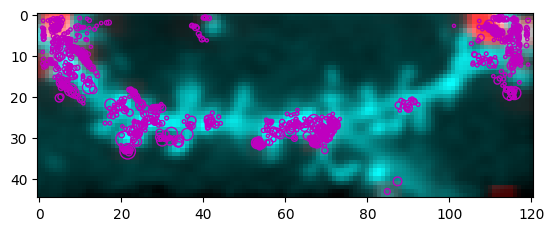

Trial: 7


OSError: Unable to create link (name already exists)

In [6]:
import os
import glob
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/'

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*_DOWNSAMPLED-2x.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+_DOWNSAMPLED-2x.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 3,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial1_ALIGNMENTDATA.h5'

# Create a temporary file for the HDF5 operations
with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
    temp_file_path = temp_file.name

# Copy contents from the original HDF5 file to the temporary file
with h5py.File(original_gt_path, 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
    for key in original_gt.keys():
        original_gt.copy(key, temp_gt)

trialIx = 0

print(f"Temporary file created at: {temp_file_path}")

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
peaks = [None] * len(strict_matching_files)
for trialIx in range(len(strict_matching_files) - 1, -1, -1):
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]

    # Load the TIFF
    IM = ScanImageTiffReader(fn)
    IM = np.array(IM.data(), dtype=np.float32).T

    meanIM = np.full((IM.shape[0], IM.shape[1], 1, len(strict_matching_files)), np.nan)

    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    meanIM[:, :, :, trialIx] = np.nanmean(IM, axis=3)

    actIM = []

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        temp_gt['aData/dsFac'] = round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()]))
        params['dsFac'] = temp_gt['aData/dsFac'][()]
        params['frametime'] = temp_gt['aData/frametime'][()]
        numChannels = temp_gt['aData/numChannels'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Subtract the moving median from aRankCorr
        tmp = aRankCorr_flat - moving_median
        
        filtTmp = smooth_exp(tmp, 'movmean', np.ceil(.2/((temp_gt['aData/frametime'][()]*temp_gt['aData/dsFac'][()]))))

        # Assuming trialIx and filtTmp are defined
        discardFrames[trialIx] = binary_dilation(filtTmp < -(4 * np.std(filtTmp)), structure=np.ones(5))

        # Assuming trialIx, IM, and discardFrames are defined
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])
        rawIMs[trialIx][:,:,discardFrames[trialIx]] = np.nan

        if numChannels == 2:
            rawIM2s[tbrialIx] = np.squeeze(IM[:,:,1,:])
            rawIM2s[trialIx][:,:,discardFrames[trialIx]] = np.nan
        
        IMc, peaks[trialIx], params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, True)

        # calculate correlation image
       # Initialize a numpy array with the desired shape and fill it with np.nan
        actIM_trial = np.full((IM.shape[0], IM.shape[1], 1), np.nan)

        # Assign values to slices of actIM_trial
        actIM_trial[IMc.shape[0]:, :, :] = np.nan
        actIM_trial[:, IMc.shape[1]:, :] = np.nan
        actIM_trial[:IMc.shape[0], :IMc.shape[1], 0] = IMc

        # Append actIM_trial to actIM
        actIM.append(actIM_trial)

        params['sz'] = meanIM.shape[:2]
        
    
actIM = np.stack(actIM, axis=3)

maxshift = 12
M = np.nansum(meanIM, axis=3)
template = make_template_multi_roi(M, maxshift)

print('Aligning across trials...')

Mpad = np.full((template.shape[0], template.shape[1], M.shape[2]), np.nan)
Mpad[maxshift:maxshift+M.shape[0], maxshift:maxshift+M.shape[1], :] = M

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

# Assuming fns, Mpad, template, maxshift, meanIM, actIM, peaks, rawIMs are defined

for trialIx in range(len(strict_matching_files)-1, -1, -1):
    trialIx = 0
    print(f'trial: {trialIx}')
    mot1 = xcorr2_nans(Mpad[:,:,trialIx], template, [0, 0], maxshift)
    motOutput[:,trialIx], corrCoeff[trialIx] = xcorr2_nans(Mpad[:,:,trialIx], template, np.round(mot1).T, maxshift)
    rr, cc = np.mgrid[1:size(meanIM,0)+1, 1:size(meanIM,1)+1]
    for chIx in range(size(meanIM,2)):
        interp_func = interp2d(cc, rr, meanIM[:,:,chIx,trialIx])
        meanAligned[:,:,chIx,trialIx] = interp_func(cc+motOutput[1,trialIx], rr+motOutput[0,trialIx])
        interp_func = interp2d(cc, rr, actIM[:,:,chIx,trialIx])
        actAligned[:,:,chIx,trialIx] = interp_func(cc+motOutput[1,trialIx], rr+motOutput[0,trialIx])
    if trialIx == len(strict_matching_files)-1:
        peaksCat['row'] = peaks[trialIx]['row'] - motOutput[0,trialIx]
        peaksCat['col'] = peaks[trialIx]['col'] - motOutput[1,trialIx]
        peaksCat['val'] = peaks[trialIx]['val']
        peaksCat['t'] = peaks[trialIx]['t']
        plt.figure()
        plt.imshow(template)
        plt.scatter(maxshift+ peaks[trialIx]['col'] - motOutput[1,trialIx], maxshift+ peaks[trialIx]['row'] - motOutput[0,trialIx])
        plt.show()
    else:
        peaksCat['row'] = np.concatenate((peaks[trialIx]['row'] - motOutput[0,trialIx], peaksCat['row']))
        peaksCat['col'] = np.concatenate((peaks[trialIx]['col'] - motOutput[1,trialIx], peaksCat['col']))
        peaksCat['val'] = np.concatenate((peaks[trialIx]['val'], peaksCat['val']))
        peaksCat['t'] = peaksCat['t'] + size(rawIMs[trialIx],2)
        peaksCat['t'] = np.concatenate((peaks[trialIx]['t'], peaksCat['t']))
        plt.scatter(maxshift+ peaks[trialIx]['col'] - motOutput[1,trialIx], maxshift+ peaks[trialIx]['row'] - motOutput[0,trialIx])
        plt.show()
    break

trial: 0


IndexError: tuple index out of range

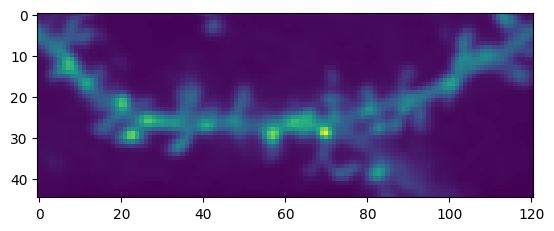

In [22]:
plt.imshow(meanIM[:,:,0,trialIx])

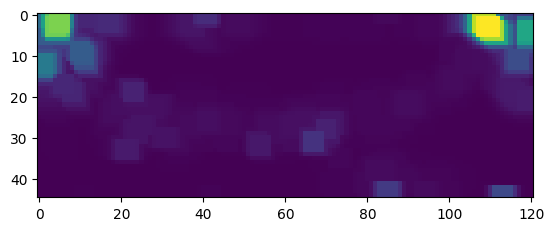

In [23]:
plt.imshow(IMc)

In [30]:
import numpy as np

if np.isnan(IMc).any():
    print("IMc contains NaN values")
else:
    print("IMc does not contain any NaN values")

IMc does not contain any NaN values


In [130]:
# Open the HDF5 file
gt = h5py.File('/root/capsule/data/iGluSnFR-testing-Sim-Data_2/1/SIMULATION_scan_00003_1_Trial1_groundtruth.h5', 'r')

# Access the dataset
dataset = gt['aData/motionC']

# Read the data
data = dataset[()]

# Don't forget to close the file when you're done
# gt.close()

In [121]:
a = gt['aData']
a['motionC']

<HDF5 dataset "motionC": shape (10000,), type "<f8">

In [133]:
gt['aData'].keys()

<KeysViewHDF5 ['aError', 'aRankCorr', 'frametime', 'motionC', 'motionDSc', 'motionDSr', 'motionR', 'numChannels']>

In [1]:
import tempfile
tempfile.gettempdir()

'/tmp'